In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
train = pd.read_csv("Aug9ValidationFeaturization.csv")
train = train.rename(columns = {'textblob_subjectvities':'textblob_subjectivities'})
train = train.drop("Unnamed: 0", axis = 1)
df = pd.read_csv("Aug9TrainingFeaturizationUpdate.csv")
df = df.drop("Unnamed: 0", axis = 1)
train = pd.concat([train, df], axis = 0)
test = pd.read_csv("Aug11TestingFeaturization.csv")
test = test.drop("Unnamed: 0", axis = 1)

In [3]:
## with help from https://towardsdatascience.com/text-classification-with-cnns-in-pytorch-1113df31e79f
import math
class TextClassifier(nn.ModuleList):

    def __init__(self, params):
        super(TextClassifier, self).__init__()

        # Parameters regarding text preprocessing
        self.seq_len = params.seq_len
        self.num_words = params.num_words
        self.embedding_size = 779

        # Dropout definition
        ##self.dropout = nn.Dropout(0.25)

        # CNN parameters definition
        # Kernel sizes
        self.kernel_1 = 2
        self.kernel_2 = 3
        self.kernel_3 = 4
        self.kernel_4 = 5

        # Output size for each convolution
        self.out_size = params.out_size
        # Number of strides for each convolution
        self.stride = params.stride

        # Embedding layer definition
        ##self.embedding = nn.Embedding(self.num_words + 1, self.embedding_size, padding_idx=0)

        # Convolution layers definition
        self.conv_1 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_1, self.stride)
        self.conv_2 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_2, self.stride)
        self.conv_3 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_3, self.stride)
        self.conv_4 = nn.Conv1d(self.seq_len, self.out_size, self.kernel_4, self.stride)

        # Max pooling layers definition
        self.pool_1 = nn.MaxPool1d(self.kernel_1, self.stride)
        self.pool_2 = nn.MaxPool1d(self.kernel_2, self.stride)
        self.pool_3 = nn.MaxPool1d(self.kernel_3, self.stride)
        self.pool_4 = nn.MaxPool1d(self.kernel_4, self.stride)

        # Fully connected layer definition
        self.fc = nn.Linear(self.in_features_fc(), 1)

    def in_features_fc(self):
        '''Calculates the number of output features after Convolution + Max pooling

        Convolved_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1
        Pooled_Features = ((embedding_size + (2 * padding) - dilation * (kernel - 1) - 1) / stride) + 1

        source: https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
        '''
        # Calcualte size of convolved/pooled features for convolution_1/max_pooling_1 features
        out_conv_1 = ((self.embedding_size - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_conv_1 = math.floor(out_conv_1)
        out_pool_1 = ((out_conv_1 - 1 * (self.kernel_1 - 1) - 1) / self.stride) + 1
        out_pool_1 = math.floor(out_pool_1)

        # Calcualte size of convolved/pooled features for convolution_2/max_pooling_2 features
        out_conv_2 = ((self.embedding_size - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_conv_2 = math.floor(out_conv_2)
        out_pool_2 = ((out_conv_2 - 1 * (self.kernel_2 - 1) - 1) / self.stride) + 1
        out_pool_2 = math.floor(out_pool_2)

        # Calcualte size of convolved/pooled features for convolution_3/max_pooling_3 features
        out_conv_3 = ((self.embedding_size - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_conv_3 = math.floor(out_conv_3)
        out_pool_3 = ((out_conv_3 - 1 * (self.kernel_3 - 1) - 1) / self.stride) + 1
        out_pool_3 = math.floor(out_pool_3)

        # Calcualte size of convolved/pooled features for convolution_4/max_pooling_4 features
        out_conv_4 = ((self.embedding_size - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_conv_4 = math.floor(out_conv_4)
        out_pool_4 = ((out_conv_4 - 1 * (self.kernel_4 - 1) - 1) / self.stride) + 1
        out_pool_4 = math.floor(out_pool_4)

        # Returns "flattened" vector (input for fully connected layer)
        return (out_pool_1 + out_pool_2 + out_pool_3 + out_pool_4) * self.out_size

    def forward(self, x):

        # Sequence of tokes is filterd through an embedding layer
        ##x = self.embedding(x)

        # Convolution layer 1 is applied
        x = x.unsqueeze(1)
        x1 = self.conv_1(x)
        x1 = torch.relu(x1)
        x1 = self.pool_1(x1)

        # Convolution layer 2 is applied
        x2 = self.conv_2(x)
        x2 = torch.relu((x2))
        x2 = self.pool_2(x2)

        # Convolution layer 3 is applied
        x3 = self.conv_3(x)
        x3 = torch.relu(x3)
        x3 = self.pool_3(x3)

        # Convolution layer 4 is applied
        x4 = self.conv_4(x)
        x4 = torch.relu(x4)
        x4 = self.pool_4(x4)

        # The output of each convolutional layer is concatenated into a unique vector
        union = torch.cat((x1, x2, x3, x4), 2)
        union = union.reshape(union.size(0), -1)

        # The "flattened" vector is passed through a fully connected layer
        out = self.fc(union)
        # Dropout is applied
        ##out = self.dropout(out)
        # Activation function is applied
        out = torch.sigmoid(out)

        return out.squeeze()

In [5]:
import numpy as np
trainscores = np.array(train.score)
testscores = np.array(test.score)

In [6]:
trainparams = train.drop(["id", "score"], axis = "columns")
testparams = test.drop(["id", "score"], axis = "columns")
trainparams = trainparams.values.tolist()
trainparams = np.asarray(trainparams)
testparams = testparams.values.tolist()
testparams = np.asarray(testparams)
trainparams = trainparams.astype(np.float32) 
testparams = testparams.astype(np.float32)
trainscores = trainscores.astype(np.float32)
testscores = testscores.astype(np.float32)

In [49]:
len(testparams[0])

779

In [7]:
from torch.utils.data import Dataset, DataLoader

class DatasetMaper(Dataset):

    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    

In [8]:
class Parameters:
    # Preprocessing parameeters
    seq_len: int = 1
    num_words: int = 779

    # Model parameters
    embedding_size: int = 779
    out_size: int = 32
    stride: int = 2

    # Training parameters
    epochs: int = 10
    batch_size: int = 12
    learning_rate: float = 0.000001
        

In [163]:
test = DatasetMaper(testparams, testscores)
loader_test = DataLoader(test, batch_size=Parameters.batch_size)
test_predictions = Run.evaluation(model, loader_test)
mean_squared_error(testscores, test_predictions)

0.023802293

In [167]:
math.sqrt(0.023802293)

0.1542799176821144

In [164]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(testscores, test_predictions))

0.062232852


In [165]:
from sklearn.metrics import r2_score
r2_score(testscores, test_predictions)

-0.479369308384624

In [166]:
adjr2 = 1-(1+0.479369308384624)*(33533-1)/(33533-779-1)
print(adjr2)

-0.5145547476186367


In [9]:
from sklearn.metrics import mean_squared_error
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
class Run:
    def train(self, model):
        params = Parameters
        # Initialize dataset maper
        train = DatasetMaper(trainparams, trainscores)
        test = DatasetMaper(testparams, testscores)

        # Initialize loaders
        loader_train = DataLoader(train, batch_size=params.batch_size)
        loader_test = DataLoader(test, batch_size=params.batch_size)

        # Define optimizer
        optimizer = optim.RMSprop(model.parameters(), lr=params.learning_rate)

        # Starts training phase
        for epoch in range(0, params.epochs):
            # Set model in training model
            model.train()
            predictions = []
            # Starts batch training
            for x_batch, y_batch in loader_train:

                y_batch = y_batch.type(torch.FloatTensor)

                # Feed the model
                y_pred = model(x_batch).float()

                # Loss calculation
                loss = F.binary_cross_entropy(y_pred, y_batch)

                # Clean gradientes
                optimizer.zero_grad()

                # Gradients calculation
                loss.backward()

                # Gradients update
                optimizer.step()

                # Save predictions
                predictions += list(y_pred.detach().numpy())
                
            # Evaluation phase
            test_predictions = Run.evaluation(model, loader_test)

            # Metrics calculation
            ## only plotting on last eppoch because otherwise it's too much
            if epoch % 2 == 0:
                Run.plot_results(test_predictions, testscores, epoch)
            if epoch % 2 == 0:
                print("Epoch", (epoch+1))
                print("MSE", mean_squared_error(testscores, test_predictions))

    def evaluation(model, loader_test):
        
        # Setting the model in evaluation mode
        model.eval()
        predictions = []
        
        # Start the evaluation phase
        with torch.no_grad():
            for x_batch, y_batch in loader_test:
                y_pred = model(x_batch)
                predictions += list(y_pred.detach().numpy())
        return predictions
    
    def plot_results(predvals, actualvals, epochnum):
        actualvalslist = list(actualvals)
        plt.scatter(actualvalslist, predvals)
        plt.ylabel("Predicted Value")
        plt.xlabel("Actual Value")
        title = "Epoch" + str(epochnum)
        plt.title(title)
        ##plt.xlim(0, 1)
        ##plt.ylim(0, 1)
        plt.plot([0, 1], [0, 1])
        plt.show()


/Users/ritubelani/opt/anaconda3/envs/SpacyEnv/lib/python3.9/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1623459065530/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


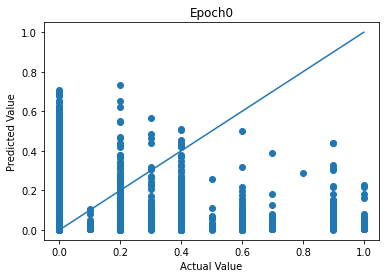

Epoch 1
MSE 0.020163234


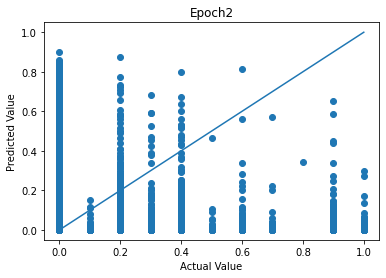

Epoch 3
MSE 0.022924501


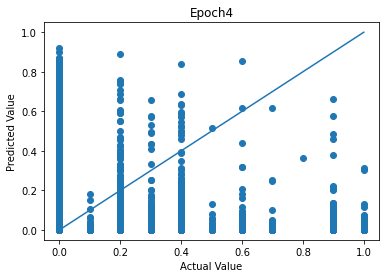

Epoch 5
MSE 0.02348093


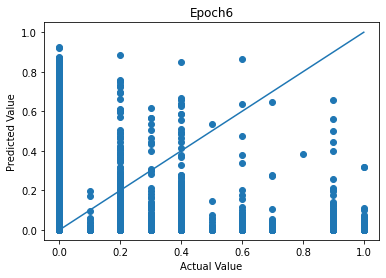

Epoch 7
MSE 0.023702873


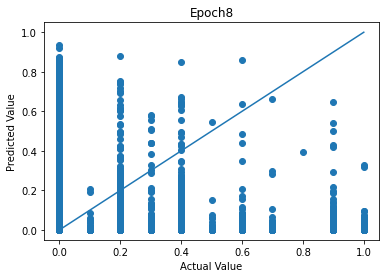

Epoch 9
MSE 0.023787426


In [10]:
model = TextClassifier(Parameters)
##100 epochs learning rate 0.000001
Run().train(model)

In [11]:
tweets = pd.read_csv('Aug11TweetsFeaturized.csv')
tweets = tweets.drop("Unnamed: 0", axis = 1)
tweets = tweets.values.tolist()
tweets = np.asarray(tweets)
tweets = tweets.astype(np.float32) 

In [23]:
tweetmapper = DatasetMaper(tweets, x)
loader_tweet = DataLoader(tweetmapper, batch_size=12)

In [32]:
model.eval()
predictions = []
        
# Start the evaluation phase
with torch.no_grad():
    for x_batch, y_batch in loader_tweet:
        y_pred = model(x_batch)
        predictions.append(y_pred)

In [81]:
cnnpreds = []
for a in range(0, )
    cnnpreds += list(y_pred.detach().numpy())

[0.02533167 0.01167412 0.02533167 0.02533167 0.02533167 0.0189874
 0.05235449 0.06718428 0.00355899 0.02619051 0.02711439 0.06921744]
[0.05196843 0.00355899 0.04249619 0.04306345 0.0395493  0.04233801
 0.06862003 0.07499357 0.00409848 0.00754211 0.00460305 0.06964611]
[0.11296628 0.00593272 0.02159992 0.00783048 0.01206602 0.01226791
 0.48476264 0.01698757 0.01289205 0.00355899 0.00355899 0.00355899]
[0.03247343 0.03456175 0.00292132 0.28794467 0.01943665 0.04021279
 0.02463244 0.00355899 0.00396859 0.00355899 0.00355899 0.03466794]
[0.08871735 0.00355899 0.00668426 0.12503946 0.0512646  0.00355899
 0.00355899 0.02448713 0.10534061 0.02331446 0.06011725 0.00355899]
[0.00668426 0.04307814 0.0152589  0.00153929 0.00355899 0.00310054
 0.00355899 0.02674296 0.02974453 0.0152589  0.02492413 0.00355899]
[0.03466794 0.05517796 0.08844136 0.00355899 0.03178157 0.01321383
 0.00940465 0.14148991 0.03690457 0.13995591 0.01020117 0.07930257]
[0.00392774 0.11957166 0.04241432 0.03690457 0.02291837 

 0.02806768 0.0182423  0.0330437  0.00548131 0.00965738 0.09236435]
[0.01718044 0.00745456 0.03511814 0.08264278 0.07729781 0.03672882
 0.09427214 0.02518579 0.03423089 0.0233218  0.07687248 0.02196195]
[0.00624594 0.05385157 0.00749894 0.01507184 0.05260003 0.03242201
 0.05454316 0.00879858 0.01818721 0.01543245 0.02120464 0.00349817]
[0.01612717 0.0492984  0.02120674 0.02001079 0.03072443 0.01072382
 0.01072382 0.01072382 0.01072382 0.01072382 0.01072382 0.01072382]
[0.01072382 0.01152313 0.00585611 0.01897497 0.02518341 0.04472369
 0.04682363 0.00984199 0.02803051 0.0388792  0.0161824  0.02513332]
[0.02295651 0.00677295 0.19294733 0.0073209  0.0281002  0.0281002
 0.02805422 0.07085567 0.02026679 0.01895566 0.02616242 0.09916412]
[0.02608716 0.02842376 0.02555359 0.05165865 0.00813009 0.01658138
 0.09186527 0.01000574 0.10833032 0.02134532 0.01051522 0.01035376]
[0.0032453  0.04666089 0.0589156  0.01000574 0.01415166 0.00387599
 0.02134532 0.02134532 0.01000574 0.01102022 0.01000574 

 0.03936243 0.0055841  0.0100857  0.08140782 0.0068348  0.0062819 ]
[0.00635221 0.00872404 0.003744   0.00986813 0.01482076 0.02556449
 0.0045115  0.07854947 0.0719437  0.07002902 0.11036614 0.00822755]
[0.00618852 0.08525737 0.00516628 0.00822755 0.00822755 0.00822755
 0.00784014 0.01784351 0.01368074 0.06266293 0.03157524 0.0861176 ]
[0.0057938  0.00174576 0.04060708 0.02504468 0.01680145 0.01180795
 0.0093418  0.0861176  0.06357183 0.19109376 0.01550023 0.04433212]
[0.00966643 0.00777694 0.00370004 0.00833995 0.0278794  0.00833995
 0.00833995 0.00833995 0.00833995 0.00833995 0.02068138 0.02081586]
[0.00833995 0.00833995 0.00833995 0.02575594 0.00833995 0.00833995
 0.00833995 0.01232208 0.00833995 0.00833995 0.00833995 0.00833995]
[0.00833995 0.00833995 0.12058767 0.00640758 0.00833995 0.16377425
 0.00833995 0.01035789 0.00833995 0.00661068 0.00833995 0.00833995]
[0.00833995 0.00833995 0.00833995 0.01352759 0.00833995 0.00833995
 0.00833995 0.00833995 0.00833995 0.00833995 0.00833995

 0.08734286 0.00936299 0.01671965 0.08734286 0.01140223 0.05158482]
[0.08734286 0.00859345 0.17223854 0.01410837 0.0111103  0.06298752
 0.00936299 0.08734286 0.01142662 0.17223854 0.0036354  0.00311703]
[0.01636479 0.01466781 0.02130905 0.02130905 0.02130905 0.01235301
 0.02130905 0.02130905 0.00529154 0.02130905 0.02130905 0.02130905]
[0.00378479 0.00290631 0.02130905 0.037815   0.02205812 0.02130905
 0.02130905 0.02130905 0.00365995 0.01913662 0.00789009 0.00606974]
[0.01380608 0.01411457 0.05025495 0.00524259 0.00741886 0.00741886
 0.00741886 0.00741886 0.00741886 0.00741886 0.00741886 0.00588727]
[0.00527834 0.02205812 0.02205812 0.02205812 0.02205812 0.00527834
 0.00527834 0.00512011 0.20176932 0.00641314 0.00570024 0.01077488]
[0.02205812 0.02781592 0.02205812 0.02205812 0.18142512 0.02205812
 0.02205812 0.02205812 0.02205812 0.02205812 0.02205812 0.01267023]
[0.01120847 0.02205812 0.00710815 0.00606152 0.02205812 0.00606152
 0.02205812 0.02205812 0.02205812 0.02205812 0.15033135

 0.03604968 0.00662673 0.00312533 0.04298822 0.00547956 0.00883227]
[0.0402829  0.01552945 0.00364162 0.00300752 0.02675785 0.0024423
 0.00704427 0.02907562 0.02534814 0.00809618 0.00695453 0.00423684]
[0.20857571 0.06023673 0.01791977 0.00662673 0.05603984 0.0043899
 0.00607121 0.00662673 0.00662673 0.00124209 0.09612597 0.0081399 ]
[0.0049623  0.00662673 0.03911292 0.00547562 0.00662673 0.0114844
 0.01573588 0.01738936 0.00760187 0.0084346  0.03521206 0.0217586 ]
[0.01296169 0.01468172 0.09220885 0.00547562 0.0497482  0.02783675
 0.0084346  0.0104976  0.00412209 0.01413351 0.02447619 0.00569848]
[0.00569848 0.06033989 0.01454928 0.00805188 0.00282937 0.01914019
 0.03866153 0.01463351 0.00247064 0.00247064 0.04054164 0.00576112]
[0.01633581 0.00247064 0.00247064 0.00247064 0.00247064 0.00189744
 0.02512167 0.00647935 0.00626777 0.16796573 0.02834879 0.06033989]
[0.00247461 0.05592479 0.02813431 0.02834879 0.12477077 0.02741996
 0.06033989 0.00877667 0.05790365 0.05396041 0.06033989 0.

 0.0054015  0.0054015  0.0054015  0.0054015  0.0054015  0.01953056]
[0.01776019 0.00706705 0.05871842 0.00849158 0.01670617 0.00377528
 0.04968282 0.00729098 0.00756514 0.00547375 0.0124194  0.00547375]
[0.09290216 0.01811018 0.06747873 0.06747873 0.05466113 0.00535125
 0.0083019  0.1106721  0.00756514 0.00440908 0.0142342  0.02377142]
[0.01964461 0.00620766 0.00700029 0.01655723 0.02951048 0.04141526
 0.06717153 0.01655723 0.01254508 0.01093003 0.01917665 0.16390014]
[0.05877641 0.04167577 0.01655723 0.02126767 0.02655205 0.04793949
 0.02425281 0.01655723 0.01465648 0.00323468 0.01655723 0.02246964]
[0.01655723 0.03383417 0.01549765 0.01655723 0.0085074  0.03500981
 0.00547375 0.01591006 0.1035258  0.02322768 0.04377921 0.01108349]
[0.03990185 0.02954446 0.04633832 0.02092752 0.02460598 0.00440651
 0.04106911 0.00541217 0.02599085 0.006946   0.02755016 0.00547375]
[0.00391658 0.01253968 0.00547375 0.01253968 0.01140723 0.14320318
 0.00491596 0.09250923 0.00942256 0.01283271 0.00266642

 0.01283271 0.06923798 0.01283271 0.01243551 0.00447669 0.01243551]
[0.01243551 0.08714692 0.06800044 0.01050917 0.06817316 0.00447669
 0.03432478 0.04487328 0.00447669 0.00447669 0.00447669 0.00447669]
[0.03383374 0.00447669 0.00447669 0.07907861 0.00447669 0.00447669
 0.04122908 0.00447669 0.04427905 0.00417475 0.02512531 0.07927779]
[0.00464366 0.02761035 0.00456931 0.04487328 0.00544467 0.04498531
 0.02356059 0.04652828 0.00447669 0.00447669 0.00447669 0.02446369]
[0.00474237 0.00559315 0.01084686 0.03526562 0.00174621 0.29145345
 0.00769104 0.00342455 0.00970617 0.29145345 0.02879299 0.20317829]
[0.07732844 0.00226174 0.00681187 0.05737593 0.06896371 0.02942248
 0.05381489 0.01000268 0.09629367 0.00475423 0.00414052 0.04269576]
[0.00285494 0.00436445 0.01478379 0.01431364 0.0338441  0.00370897
 0.01431364 0.01328572 0.01781457 0.01431364 0.00775277 0.01431364]
[0.01431364 0.01431364 0.01431364 0.01505768 0.01431364 0.01431364
 0.01431364 0.01431364 0.00785087 0.02700031 0.08908072

 0.01522845 0.01942477 0.01522845 0.01522845 0.01522845 0.00695389]
[0.01522845 0.02712068 0.01522845 0.01522845 0.01522845 0.09882812
 0.01522845 0.01235707 0.01522845 0.00697441 0.013391   0.01522845]
[0.01522845 0.01522845 0.01522845 0.0549265  0.01522845 0.01522845
 0.01522845 0.01522845 0.01522845 0.01522845 0.01522845 0.01522845]
[0.01522845 0.013916   0.01522845 0.01522845 0.01307447 0.01522845
 0.01522845 0.01522845 0.01522845 0.01522845 0.01522845 0.00699322]
[0.0996412  0.00317711 0.01522845 0.01522845 0.00608056 0.01522845
 0.00608056 0.02835157 0.01522845 0.00608056 0.08887229 0.01522845]
[0.06463478 0.00608056 0.00608056 0.18846075 0.00608056 0.00608056
 0.00608056 0.00490906 0.01522845 0.01522845 0.01522845 0.01522845]
[0.07450072 0.00278865 0.00666682 0.01009558 0.01795327 0.00688072
 0.00917189 0.20150702 0.0258574  0.04742021 0.01004435 0.00654006]
[0.01554818 0.04640922 0.01253089 0.1701567  0.02368511 0.01292045
 0.07826389 0.07450072 0.07450072 0.07450072 0.07450072

[0.01993426 0.01993426 0.00421396 0.01993426 0.01993426 0.01993426
 0.12901448 0.12901448 0.12901448 0.01993426 0.12901448 0.13736574]
[0.12901448 0.12901448 0.0119448  0.12901448 0.12901448 0.00276274
 0.03125751 0.02083826 0.01092026 0.12901448 0.12901448 0.12901448]
[0.02670864 0.02209019 0.01590867 0.00778861 0.01993426 0.01993426
 0.12901448 0.12901448 0.00343705 0.12901448 0.12901448 0.029496  ]
[0.10902835 0.21298309 0.02309116 0.02047453 0.00610186 0.12901448
 0.04281747 0.00913666 0.13736574 0.12901448 0.12901448 0.01993426]
[0.12901448 0.04100589 0.00564345 0.08684205 0.12901448 0.00659277
 0.0040158  0.0047033  0.01993426 0.08684205 0.00555929 0.12901448]
[0.08219081 0.12901448 0.08928102 0.12901448 0.01414455 0.12901448
 0.12901448 0.12901448 0.01993426 0.12901448 0.12901448 0.12901448]
[0.12901448 0.01993426 0.07844952 0.00669576 0.12901448 0.12901448
 0.05313033 0.01993426 0.04730051 0.04794069 0.04024102 0.0127887 ]
[0.12901448 0.0156625  0.12901448 0.12901448 0.12901448

 0.0070396  0.00285591 0.01387256 0.00477875 0.0906787  0.00285591]
[0.00285591 0.00285591 0.00285591 0.00285591 0.00285591 0.00285591
 0.00285591 0.00285591 0.00285591 0.00285591 0.00285591 0.00285591]
[0.00285591 0.00702115 0.00285591 0.02839822 0.00285591 0.00285591
 0.00285591 0.00285591 0.04673536 0.00285591 0.00285591 0.06947137]
[0.00285591 0.00285591 0.00285591 0.00285591 0.00285591 0.00285591
 0.00285591 0.28812414 0.00285591 0.00285591 0.00285591 0.00285591]
[0.00285591 0.00285591 0.00489007 0.00285591 0.00285591 0.00303821
 0.00285591 0.00796918 0.00285591 0.00285591 0.00285591 0.00285591]
[0.00285591 0.00285591 0.02834879 0.00285591 0.00899358 0.00285591
 0.00454877 0.00285591 0.00647696 0.06128538 0.00285591 0.00313987]
[0.02834879 0.02068917 0.00285591 0.00285591 0.00732654 0.02265397
 0.01471012 0.00285591 0.00285591 0.00285591 0.00285591 0.14923881]
[0.00285591 0.02386897 0.00285591 0.01331015 0.05533119 0.03797086
 0.00285591 0.05533119 0.00285591 0.00285591 0.00285591

[0.00285591 0.01410549 0.01324074 0.0368031  0.07174062 0.02745192
 0.00498945 0.05405295 0.02728121 0.03763294 0.0100502  0.0100502 ]
[0.00812705 0.07368179 0.00738927 0.01441199 0.01455914 0.08148205
 0.01935023 0.08583424 0.03931774 0.05030121 0.01277169 0.07478783]
[0.0531262  0.00615275 0.13152178 0.06800175 0.2317041  0.00396892
 0.00309731 0.01178065 0.03149688 0.07148633 0.01430728 0.01825823]
[0.00242753 0.00237802 0.14120427 0.05268024 0.01196553 0.00285591
 0.05784193 0.01247276 0.03015242 0.05464609 0.03469821 0.01532065]
[0.00998662 0.00998662 0.00400833 0.01258499 0.03290426 0.00998662
 0.0022934  0.04379812 0.00998662 0.00703465 0.00859925 0.00998662]
[0.01732772 0.00998662 0.00915436 0.0405825  0.00998662 0.00998662
 0.00170616 0.00998662 0.01421229 0.00998662 0.00998662 0.00998662]
[0.00998662 0.10899561 0.00703465 0.00998662 0.00703465 0.0405825
 0.00998662 0.00703465 0.01421229 0.00998662 0.00998662 0.00998662]
[0.00998662 0.00998662 0.00998662 0.00998662 0.00998662 

 0.00712133 0.00575465 0.04511432 0.00262574 0.00876896 0.01172321]
[0.03986114 0.00089198 0.01369852 0.00187505 0.00668865 0.00772267
 0.00867233 0.00374939 0.00836401 0.00089198 0.01936516 0.00928479]
[0.03636882 0.04095529 0.01880469 0.00394321 0.01430199 0.02145555
 0.00537816 0.09488656 0.07183363 0.01713545 0.02478611 0.01169703]
[0.17525747 0.05972685 0.10337964 0.00899732 0.00778043 0.06023961
 0.04460244 0.01796646 0.01826867 0.01103375 0.20073223 0.04999896]
[0.00185964 0.00892917 0.01942507 0.06073452 0.01795825 0.04767489
 0.02839644 0.01299572 0.02365406 0.01659787 0.01706014 0.00578983]
[0.01186423 0.03356908 0.00581742 0.21003866 0.02832959 0.12046848
 0.00356021 0.03036193 0.01290683 0.06215369 0.06306779 0.04648115]
[0.05301937 0.02069405 0.04148689 0.05946463 0.02069405 0.03511675
 0.0132679  0.01572633 0.01995182 0.04137145 0.05042948 0.06701003]
[0.01755646 0.03443577 0.02446391 0.07042002 0.13446657 0.04349038
 0.1479395  0.20388994 0.02588645 0.19245769 0.07997249

 0.00677295 0.05662142 0.04897336 0.04897336 0.00677295 0.02514938]
[0.02396196 0.04149863 0.03807149 0.02396196 0.04217635 0.00677295
 0.00677295 0.01522982 0.00899129 0.00899129 0.00677295 0.05272657]
[0.00452883 0.05376069 0.04914137 0.12902024 0.0081302  0.02003642
 0.00677295 0.01070463 0.04730379 0.03710382 0.00677295 0.10642212]
[0.00215333 0.09835885 0.00677295 0.00677295 0.00677295 0.00677295
 0.00677295 0.0490251  0.14190279 0.00677295 0.00919946 0.00677295]
[0.00677295 0.00677295 0.00677295 0.00677295 0.00677295 0.00677295
 0.00677295 0.00677295 0.00677295 0.00677295 0.00677295 0.00677295]
[0.00677295 0.00677295 0.00677295 0.00677295 0.00518048 0.08462453
 0.02242528 0.00883993 0.01897654 0.02520737 0.15539323 0.03775063]
[0.08872961 0.02626712 0.01273728 0.00883993 0.08902579 0.00215333
 0.01152464 0.00380184 0.26570302 0.0546242  0.02639586 0.0127986 ]
[0.00337461 0.06677078 0.01763426 0.00979725 0.02229652 0.02401581
 0.00551762 0.02065352 0.01447542 0.02993752 0.02386083

 0.00320497 0.00859759 0.00361828 0.00414273 0.00361828 0.04664122]
[0.00361828 0.00859759 0.00361828 0.00361828 0.00361828 0.00361828
 0.00361828 0.00361828 0.00361828 0.01988154 0.00361828 0.00361828]
[0.00361828 0.00361828 0.00361828 0.00859759 0.00889537 0.00623377
 0.00361828 0.00859759 0.00361828 0.00361828 0.00361828 0.00361828]
[0.00361828 0.00361828 0.00361828 0.00361828 0.02757109 0.00361828
 0.00859759 0.00361828 0.00361828 0.00361828 0.00361828 0.00361828]
[0.00361828 0.00361828 0.00361828 0.00361828 0.00361828 0.00361828
 0.00361828 0.00361828 0.00361828 0.00361828 0.00361828 0.00361828]
[0.00361828 0.00361828 0.00361828 0.00361828 0.00361828 0.00361828
 0.00361828 0.00859759 0.00859759 0.00514212 0.00859759 0.00859759]
[0.00361828 0.00714852 0.03697518 0.00773512 0.02743782 0.02317079
 0.02452226 0.06148268 0.00691613 0.02644879 0.00585331 0.00682268]
[0.00655215 0.02026025 0.02945704 0.03286141 0.07173474 0.01171206
 0.12901448 0.05592634 0.0574424  0.00860274 0.26691148

 0.00207609 0.00207428 0.09371635 0.00576928 0.01253968 0.01253968]
[0.04248177 0.00981739 0.01253968 0.01253968 0.05477529 0.01296733
 0.05370522 0.0570284  0.05370522 0.00266642 0.01558916 0.08749241]
[0.05370522 0.05370522 0.05370522 0.05370522 0.05370522 0.05370522
 0.05370522 0.05370522 0.02524659 0.00892757 0.01246114 0.05370522]
[0.05370522 0.01264153 0.05370522 0.00266642 0.00785393 0.1165975
 0.07525096 0.10121851 0.05370522 0.05370522 0.05370522 0.01681748]
[0.05370522 0.04923119 0.05370522 0.05370522 0.00266642 0.05370522
 0.05370522 0.05370522 0.02143592 0.05370522 0.08974843 0.00266642]
[0.05370522 0.05370522 0.05370522 0.05370522 0.05370522 0.05370522
 0.05370522 0.05370522 0.05370522 0.05370522 0.05370522 0.00266642]
[0.05370522 0.05010489 0.05370522 0.00266642 0.05370522 0.00266642
 0.03460827 0.05370522 0.05370522 0.05370522 0.05370522 0.01638288]
[0.04531669 0.05370522 0.05370522 0.05370522 0.00727063 0.05370522
 0.05370522 0.05370522 0.05370522 0.05370522 0.05370522 

 0.01894083 0.01059922 0.23349735 0.01276186 0.01742463 0.01163252]
[0.00284686 0.04756677 0.02700776 0.0214991  0.03986653 0.12790465
 0.00420088 0.01651762 0.00503201 0.00887282 0.00503201 0.00503201]
[0.05259224 0.01182709 0.00439858 0.00702458 0.00908831 0.00439842
 0.00793811 0.11336316 0.01591375 0.0166642  0.01591375 0.01591375]
[0.0111974  0.0016132  0.04767571 0.0016132  0.01010161 0.02843091
 0.00895981 0.01779528 0.15820816 0.0077808  0.0016132  0.0016132 ]
[0.0016132  0.00261097 0.01753129 0.06116328 0.02276807 0.10139874
 0.13923267 0.07170977 0.0494149  0.01296976 0.04748907 0.0629547 ]
[0.01779528 0.01779528 0.00894072 0.00241634 0.01591375 0.0407018
 0.0407018  0.01779528 0.02355818 0.0214976  0.0143347  0.0096821 ]
[0.01190065 0.0096821  0.0056913  0.02168888 0.01824151 0.02643195
 0.01591375 0.01779528 0.01779528 0.01779528 0.01779528 0.01779528]
[0.02337369 0.01779528 0.01779528 0.01779528 0.02554063 0.02942276
 0.01591375 0.00204381 0.00999673 0.00607428 0.0096821  

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [ ]:
cnndf = pd.DataFrame()
cnndf["score"] = cnnpreds
cnndf.to_csv("CNNTweets.csv")